#### Objective 1: Identifying psychiatric disorders and psychotropic medications associated with increased ICU readmission.

/tmp/ipykernel_23395/2070397506.py:32: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  rx      = pd.read_csv('./data/psych_prescriptions.csv')


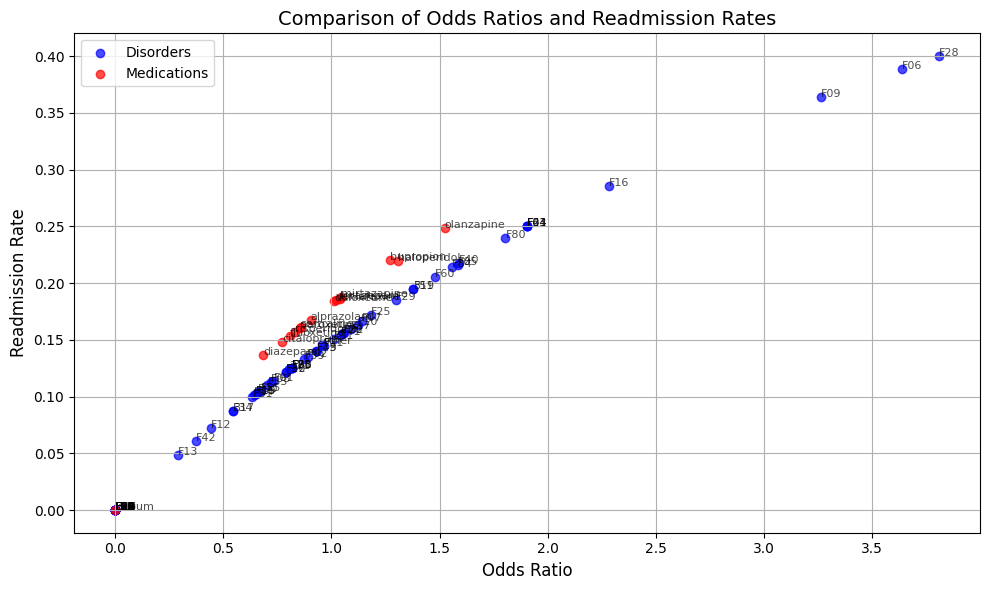

Top 10 psychiatric disorders with highest odds of readmission:
dx_group  n_adm  readm_rate    ci_low  ci_high  odds_ratio  p_value
     F28      5    0.400000 -0.029414 0.829414    3.809257 0.162890
     F06     36    0.388889  0.229640 0.548138    3.640532 0.000383
     F09     11    0.363636  0.079357 0.647916    3.265672 0.067962
     F16      7    0.285714 -0.048950 0.620378    2.285442 0.280538
     F44     40    0.250000  0.115808 0.384192    1.905503 0.077206
     F04      8    0.250000 -0.050062 0.550062    1.904489 0.339558
     F63      8    0.250000 -0.050062 0.550062    1.904489 0.339558
     F21      4    0.250000 -0.174352 0.674352    1.904362 0.475473
     F80     25    0.240000  0.072583 0.407417    1.804688 0.252936
     F40     69    0.217391  0.120066 0.314716    1.588097 0.125563

Top 10 psychotropic medications with highest odds of readmission:
       drug  n_adm  readm_rate   ci_low  ci_high  odds_ratio      p_value
 olanzapine   1423    0.248770 0.226309 0.271232

In [ ]:

import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from statsmodels.stats.contingency_tables import Table2x2
ignore_warnings = True

def icd_group(code: str) -> str:
    """
    Collapse an ICD‑9 or ICD‑10 psychiatric code to a disorder ‘bucket’
    """
    code = str(code).strip()
    if code.startswith('F'):
        return code[:3]          # ICD‑10 psych
    try:
        num = int(code.split('.')[0])
        if 290 <= num <= 319:    # ICD‑9 psych range
            return str(num)[:3]
    except ValueError:
        pass
    return 'other'

def rate_ci(k, n, z=1.96):
    """Approximate 95 % CI for a proportion (Wald)."""
    p = k / n
    se = np.sqrt(p * (1 - p) / n)
    return p, p - z*se, p + z*se

icu_adm = pd.read_csv('./data/icu_psych_readmissions.csv',
                      parse_dates=['next_admission', 'dischtime'])
diag    = pd.read_csv('./data/psych_diagnoses.csv')
rx      = pd.read_csv('./data/psych_prescriptions.csv')

# Psychiatric DISORDERS vs 30‑day ICU readmission
diag['dx_group'] = diag['icd_code'].apply(icd_group)

# One row per hospital admission / disorder bucket
adm_dx = (diag[['hadm_id','dx_group']]
          .drop_duplicates()
          .merge(icu_adm[['hadm_id','readmitted_30d']], on='hadm_id'))

results_dx = []
for g, grp in adm_dx.groupby('dx_group'):
    # 2x2 table
    readm_yes = grp['readmitted_30d'].sum()
    readm_no  = grp['readmitted_30d'].size - readm_yes

    other     = adm_dx[adm_dx['dx_group'] != g]
    other_yes = other['readmitted_30d'].sum()
    other_no  = other.shape[0] - other_yes

    table = np.array([[readm_yes, readm_no],
                      [other_yes, other_no]])

    OR, p = fisher_exact(table)
    rate, low, high = rate_ci(readm_yes, readm_yes + readm_no)

    results_dx.append((g, readm_yes + readm_no, rate, low, high, OR, p))

dx_stats = (pd.DataFrame(results_dx,
             columns=['dx_group','n_adm','readm_rate',
                      'ci_low','ci_high','odds_ratio','p_value'])
            .sort_values('odds_ratio', ascending=False))
dx_labels = pd.read_csv('./data/hosp/d_icd_diagnoses.csv')

dx_stats.merge(dx_labels[['icd_code','long_title']], 
                 left_on='dx_group', right_on='icd_code',
                 how='left').set_index('dx_group')
# PSYCHOTROPIC medications vs readmission
# Flag each admission that ever received a given drug
adm_rx = (rx[['hadm_id','drug']]
          .drop_duplicates()
          .merge(icu_adm[['hadm_id','readmitted_30d']], on='hadm_id'))

results_rx = []
for d, grp in adm_rx.groupby('drug'):
    readm_yes = grp['readmitted_30d'].sum()
    readm_no  = grp.shape[0] - readm_yes

    other     = adm_rx[adm_rx['drug'] != d]
    other_yes = other['readmitted_30d'].sum()
    other_no  = other.shape[0] - other_yes

    table = np.array([[readm_yes, readm_no],
                      [other_yes, other_no]])

    OR, p = fisher_exact(table)
    rate, low, high = rate_ci(readm_yes, readm_yes + readm_no)
    results_rx.append((d, readm_yes + readm_no, rate, low, high, OR, p))

rx_stats = (pd.DataFrame(results_rx,
             columns=['drug','n_adm','readm_rate',
                      'ci_low','ci_high','odds_ratio','p_value'])
            .sort_values('odds_ratio', ascending=False))

import matplotlib.pyplot as plt

# Plot to compare the odds
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for disorders
ax.scatter(dx_stats['odds_ratio'], dx_stats['readm_rate'], color='blue', label='Disorders', alpha=0.7)
for i, txt in enumerate(dx_stats['dx_group']):
    ax.annotate(txt, (dx_stats['odds_ratio'].iloc[i], dx_stats['readm_rate'].iloc[i]), fontsize=8, alpha=0.7)

# Plot for medications
ax.scatter(rx_stats['odds_ratio'], rx_stats['readm_rate'], color='red', label='Medications', alpha=0.7)
for i, txt in enumerate(rx_stats['drug']):
    ax.annotate(txt, (rx_stats['odds_ratio'].iloc[i], rx_stats['readm_rate'].iloc[i]), fontsize=8, alpha=0.7)

# Add labels and legend
ax.set_xlabel('Odds Ratio', fontsize=12)
ax.set_ylabel('Readmission Rate', fontsize=12)
ax.set_title('Comparison of Odds Ratios and Readmission Rates', fontsize=14)
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


print("Top 10 psychiatric disorders with highest odds of readmission:")
print(dx_stats.head(10).to_string(index=False))
print("\nTop 10 psychotropic medications with highest odds of readmission:")
print(rx_stats.head(10).to_string(index=False))

#### Objective 2: Evaluating if discontinuation or improper reconciliation of psychiatric medications at discharge contributes to higher readmission risks.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
import statsmodels.api as sm

# ----------------------------------------------------------------
# 1.  Load the cohort tables 
# ----------------------------------------------------------------
icu  = pd.read_csv('./data/icu_psych_readmissions.csv',
                   parse_dates=['dischtime'])          # hadm_id, subject_id, dischtime, readmitted_30d
last = pd.read_csv('./data/last_prescriptions_processed.csv',
                   parse_dates=['last_psych_med_time'])  # hadm_id, last_psych_med_time

# keep only admissions where we know at least one psych med was ordered
cohort = (icu.merge(last, on='hadm_id', how='inner')
             .copy())

# ----------------------------------------------------------------
# 2.  Define “discontinued / improperly reconciled” flag
# ----------------------------------------------------------------
#
# If the final stop‑time of any psych drug comes ≥ 24 h BEFORE hospital
#   discharge → assumed **discontinued** (or not restarted) at discharge.
# If stop‑time is NaT   → assumed **continued** or tapered at discharge.
# If stop‑time falls within the last 24 h before discharge
#   treat it as **continued** (you can tighten / relax this window).
#
MARGIN  = pd.Timedelta('24h')

cohort['psych_discontinued'] = (
        cohort['last_psych_med_time'].notna() & 
        (cohort['last_psych_med_time'] < cohort['dischtime'] - MARGIN)
)

# ----------------------------------------------------------------
# 3.  2×2 table, odds ratio, (Chi-square)Fisher exact p‑value
# ----------------------------------------------------------------
tbl = pd.crosstab(cohort['psych_discontinued'], cohort['readmitted_30d'])
display(tbl)                                    # raw counts

OR, p_val = fisher_exact(tbl.values)            # two‑sided
print(f"Odds ratio = {OR:0.2f},  p = {p_val:0.4g}")

# crude risk difference & Wald CI
def rate_ci(k, n, z=1.96):
    p = k / n
    se = np.sqrt(p * (1-p) / n)
    return p, p - z*se, p + z*se

disc_yes = tbl.loc[True ]
disc_no  = tbl.loc[False]

rate_yes, lo_yes, hi_yes = rate_ci(disc_yes[1], disc_yes.sum())
rate_no , lo_no , hi_no  = rate_ci(disc_no [1], disc_no .sum())

print(f"\n30‑day readmission:")
print(f"  • Discontinued meds  : {rate_yes:0.1%}  (95 % CI {lo_yes:0.1%}–{hi_yes:0.1%})")
print(f"  • Continued/tapered  : {rate_no :0.1%}  (95 % CI {lo_no :0.1%}–{hi_no :0.1%})")

# ----------------------------------------------------------------
# 4.  logistic model
# ----------------------------------------------------------------
X = pd.DataFrame({
    'disc': cohort['psych_discontinued'].astype(int),
    'const': 1
})
y = cohort['readmitted_30d'].astype(int)

model = sm.Logit(y, X).fit(disp=False)
print(model.summary())


readmitted_30d,False,True
psych_discontinued,,
False,10862,1912
True,3015,831


Odds ratio = 1.57,  p = 2.861e-21

30‑day readmission:
  • Discontinued meds  : 21.6%  (95 % CI 20.3%–22.9%)
  • Continued/tapered  : 15.0%  (95 % CI 14.3%–15.6%)


/tmp/ipykernel_23395/3751231815.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rate_yes, lo_yes, hi_yes = rate_ci(disc_yes[1], disc_yes.sum())
/tmp/ipykernel_23395/3751231815.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rate_no , lo_no , hi_no  = rate_ci(disc_no [1], disc_no .sum())


                           Logit Regression Results                           
Dep. Variable:         readmitted_30d   No. Observations:                16620
Model:                          Logit   Df Residuals:                    16618
Method:                           MLE   Df Model:                            1
Date:                Sun, 20 Apr 2025   Pseudo R-squ.:                0.006040
Time:                        20:50:29   Log-Likelihood:                -7399.7
converged:                       True   LL-Null:                       -7444.7
Covariance Type:            nonrobust   LLR p-value:                 2.460e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
disc           0.4484      0.046      9.670      0.000       0.358       0.539
const         -1.7371      0.025    -70.043      0.000      -1.786      -1.689


In [1]:
# ================================================================
# Objective 3 – Top feature influence on 30‑day ICU readmission
# ================================================================
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt



# ----------------------------------------------------------------
# 1.  Assemble one row per *admission* with engineered features
# ----------------------------------------------------------------
base      = pd.read_csv('./data/icu_psych_readmissions.csv',
                        parse_dates=['intime','outtime','dischtime'])
last_rx   = pd.read_csv('./data/last_prescriptions_processed.csv',
                        parse_dates=['last_psych_med_time'])
diag['dx_group'] = diag['icd_code'].apply(icd_bucket).astype(str)   # <- cast to str
rx        = pd.read_csv('./data/psych_prescriptions.csv')
patients  = pd.read_csv('./data/hosp/patients.csv', usecols=['subject_id','gender','anchor_age'])

# --- outcome ----------------------------------------------------
y = base.set_index('hadm_id')['readmitted_30d']

# --- LOS & ICU metrics -----------------------------------------
base['icu_los_hrs'] = (pd.to_datetime(base['outtime']) - pd.to_datetime(base['intime'])).dt.total_seconds() / 3600

# --- psych med discontinuation flag (from Objective 2) ----------
MARGIN = pd.Timedelta('24h')
tmp = last_rx.set_index('hadm_id')['last_psych_med_time']
base = base.join(tmp, on='hadm_id')
base['psych_discontinued'] = (
        base['last_psych_med_time'].notna() &
        (base['last_psych_med_time'] < base['dischtime'] - MARGIN)
)

# --- number of psych meds & med categories ----------------------
rx['drug'] = rx['drug'].str.lower()
med_count = (rx.groupby('hadm_id')['drug']
               .agg(n_psych_meds='nunique')
               .reindex(base['hadm_id'])
               .fillna(0)
               .astype(int))
base = base.join(med_count)

# --- disorder buckets (3‑digit ICD prefix) ----------------------
def icd_bucket(code):
    code = str(code).strip()
    if code.startswith('F'):           # ICD‑10
        return code[:3]                # e.g. "F20"
    try:                               # ICD‑9 290‑319
        icd = int(code.split('.')[0])
        if 290 <= icd <= 319:
            return f"{icd:03d}"        # -> "296", "295", …
    except ValueError:
        pass
    return np.nan 

diag['dx_group'] = diag['icd_code'].apply(icd_bucket)

dx_buckets = (diag.dropna(subset=['dx_group'])
                 .pivot_table(index='hadm_id',
                              columns='dx_group',
                              values='icd_code',
                              aggfunc='size',
                              fill_value=0,
                              sort=False))
dx_buckets.index = dx_buckets.index.astype('int64', copy=False)

base = base.merge(dx_buckets,         
                  left_on='hadm_id',
                  right_index=True,
                  how='left')         
base = base.fillna(0)

# --- demographics ----------------------------------------------
base = base.merge(patients, on='subject_id', how='left')

# final feature frame
X = base.set_index('hadm_id').drop(
        columns=['readmitted_30d','intime','outtime','dischtime',
                 'last_psych_med_time']           # drop dates
     )
print(f"Feature matrix shape: {X.shape}")

# ----------------------------------------------------------------
# 2.  Train / test split *by patient*
# ----------------------------------------------------------------
train_ids, test_ids = train_test_split(
        X.index, test_size=0.2, random_state=42,
        stratify=y
)
X_train, X_test = X.loc[train_ids], X.loc[test_ids]
y_train, y_test = y.loc[train_ids], y.loc[test_ids]

# ----------------------------------------------------------------
# 3.  Pre‑processing pipeline
# ----------------------------------------------------------------
num_cols = X.select_dtypes(include=['int','float']).columns.tolist()
cat_cols = ['gender']                         # one‑hot encode gender

pre = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])

# ----------------------------------------------------------------
# 4‑A.  Regularised logistic regression (baseline)
# ----------------------------------------------------------------
logreg = Pipeline([
    ('prep', pre),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear',
                               penalty='l1', C=1.0))
])
logreg.fit(X_train, y_train)

pred_train = logreg.predict_proba(X_train)[:,1]
pred_test  = logreg.predict_proba(X_test)[:,1]

print("\nLogistic regression:")
print(f"  Train AUROC: {roc_auc_score(y_train, pred_train):0.3f}")
print(f"  Test  AUROC: {roc_auc_score(y_test , pred_test ):0.3f}")
print(f"  Test  AUPRC: {average_precision_score(y_test, pred_test):0.3f}")

# ----------------------------------------------------------------
# 4‑B.  Gradient‑boosted trees (non‑linear)
# ----------------------------------------------------------------
gb = Pipeline([
    ('prep', pre),
    ('clf', GradientBoostingClassifier(n_estimators=400,
                                       learning_rate=0.05,
                                       max_depth=3,
                                       subsample=0.9,
                                       random_state=42))
])
gb.fit(X_train, y_train)
pred_test_gb = gb.predict_proba(X_test)[:,1]
print("\nGradient Boosting:")
print(f"  Test AUROC: {roc_auc_score(y_test, pred_test_gb):0.3f}")
print(f"  Test AUPRC: {average_precision_score(y_test, pred_test_gb):0.3f}")

# ----------------------------------------------------------------
# 5.  Confusion matrix at threshold 0.5 (GB model)
# ----------------------------------------------------------------
th = 0.5
y_hat = (pred_test_gb >= th).astype(int)
print("\nConfusion matrix (threshold 0.5, GB):")
print(confusion_matrix(y_test, y_hat))
print("\nClassification Report:")
print(classification_report(y_test, y_hat, digits=3))

num_feats = list(pre.transformers_[0][2])
cat_encoder = gb.named_steps['prep'].named_transformers_['cat']
cat_feats   = cat_encoder.get_feature_names_out(cat_cols).tolist()

feature_names = num_feats + cat_feats

# ----------------------------------------------------------------
# 6.  Simple feature importance plot (GB)
# ----------------------------------------------------------------
imp = gb.named_steps['clf'].feature_importances_

fi  = (pd.Series(imp, index=feature_names)
         .sort_values(ascending=False)[:20])

plt.figure(figsize=(6,4))
fi[::-1].plot(kind='barh')
plt.title("Top 20 features (Gradient Boosting)")
plt.tight_layout(); plt.show()


ModuleNotFoundError: No module named 'sklearn'

In [1]:
import pandas as pd

df = pd.read_csv('./data/hosp/labevents.csv')

df.head()


,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,1,10000032,NaN,45421181,51237,2180-03-23 11:51:00,2180-03-23 15:15:00,1.4,1.4,NaN,0.9,1.1,abnormal,ROUTINE,NaN
1,2,10000032,NaN,45421181,51274,2180-03-23 11:51:00,2180-03-23 15:15:00,___,15.1,sec,9.4,12.5,abnormal,ROUTINE,VERIFIED.
2,3,10000032,NaN,52958335,50853,2180-03-23 11:51:00,2180-03-25 11:06:00,___,15.0,ng/mL,30.0,60.0,abnormal,ROUTINE,NEW ASSAY IN USE ___: DETECTS D2 AND D3 25-OH ...
3,4,10000032,NaN,52958335,50861,2180-03-23 11:51:00,2180-03-23 16:40:00,102,102.0,IU/L,0.0,40.0,abnormal,ROUTINE,NaN
4,5,10000032,NaN,52958335,50862,2180-03-23 11:51:00,2180-03-23 16:40:00,3.3,3.3,g/dL,3.5,5.2,abnormal,ROUTINE,NaN
